In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)
from numpy.random import seed
#from scipy.io import netcdf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [ ]:
###########################################################################################################

In [ ]:
# pick sample6 , the clearly visualized outliers

proj = ["BB_25496023", "BB_25496025", "BB_25510027", "BB_26471092",
        "BB_27410202", "BB_27450129", "BB_27471020", "BB_28370023","RP_2375255000"]

ts = grouped_t_s.loc[proj]
temp = ave_temp.loc[proj]
prec = cum_prec.loc[proj]
#ts.to_csv(f"dataset/modeling/sample6/ts.csv")
#temp.to_csv(f"dataset/modeling/sample6/temp.csv")
#prec.to_csv(f"dataset/modeling/sample6/prec.csv")

In [4]:
# import sample6
grouped_t_s= pd.read_csv(f"dataset/modeling/sample6/ts.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
ave_temp= pd.read_csv(f"dataset/modeling/sample6/temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
cum_prec= pd.read_csv(f"dataset/modeling/sample6/prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(grouped_t_s.shape)
print(ave_temp.shape)
print(cum_prec.shape)

(9, 6546)
(9, 6546)
(9, 6546)


# func

In [6]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


# pick up one ts with its corresponding temp and prec, and plot them all

ts length:4240.0, freq: 1.0,lag: 200.0 days
(4240, 3)


Text(0.5, 1.0, 'prec')

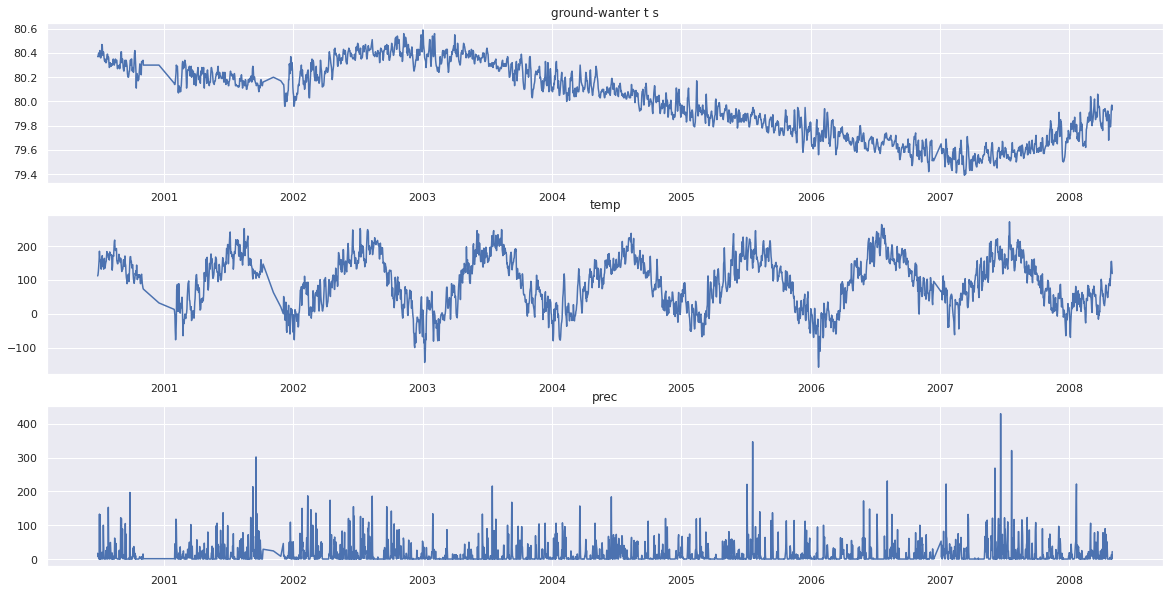

In [7]:
# apply the func RP_2375255000, BB_27410202
ts1 = grouped_t_s.iloc[3] 
#ts1 = grouped_t_s.loc["BB_27410202"]
lag = int(200/ts1[1]) # lag of 200 days
print(f"ts length:{ts1[0]}, freq: {ts1[1]},lag: {lag*ts1[1]} days")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,2700
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

In [8]:
def series_to_supervised(data, n_in=lag, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
idx = df.index[lag:]
df =series_to_supervised(df.values)
df.index=idx
df

,var1(t-200),var2(t-200),var3(t-200),var1(t-199),var2(t-199),var3(t-199),var1(t-198),var2(t-198),var3(t-198),var1(t-197),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2001-04-10,80.37,112.0,17.0,80.37,116.0,7.0,80.39,126.0,15.0,80.40,...,13.0,80.23,79.0,15.0,80.18,63.0,0.0,80.21,77.0,1.0
2001-04-11,80.37,116.0,7.0,80.39,126.0,15.0,80.40,143.0,2.0,80.37,...,15.0,80.18,63.0,0.0,80.21,77.0,1.0,80.19,74.0,3.0
2001-04-12,80.39,126.0,15.0,80.40,143.0,2.0,80.37,157.0,0.0,80.38,...,0.0,80.21,77.0,1.0,80.19,74.0,3.0,80.18,35.0,37.0
2001-04-13,80.40,143.0,2.0,80.37,157.0,0.0,80.38,185.0,133.0,80.42,...,1.0,80.19,74.0,3.0,80.18,35.0,37.0,80.16,11.0,3.0
2001-04-14,80.37,157.0,0.0,80.38,185.0,133.0,80.42,166.0,0.0,80.41,...,3.0,80.18,35.0,37.0,80.16,11.0,3.0,80.15,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-12,80.42,-37.0,0.0,80.41,-32.0,0.0,80.40,-35.0,0.0,80.38,...,0.0,80.54,142.0,2.0,80.54,153.0,0.0,80.56,152.0,0.0
2012-08-13,80.41,-32.0,0.0,80.40,-35.0,0.0,80.38,-56.0,0.0,80.36,...,2.0,80.54,153.0,0.0,80.56,152.0,0.0,80.57,158.0,0.0
2012-08-14,80.40,-35.0,0.0,80.38,-56.0,0.0,80.36,-56.0,0.0,80.35,...,0.0,80.56,152.0,0.0,80.57,158.0,0.0,80.58,158.0,0.0
2012-08-15,80.38,-56.0,0.0,80.36,-56.0,0.0,80.35,-69.0,0.0,80.36,...,0.0,80.57,158.0,0.0,80.58,158.0,0.0,80.58,166.0,0.0


# Autoencoder LSTM model: 

In [9]:

# split df into train 80% and test 20%, 
n_train = int(len(df)*0.8)
train = df[:n_train]
test = df[n_train:]

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (3232, 1, 603)
Test data shape: (808, 1, 603)


In [10]:
# define the autoencoder network model
def autoencoder_model(X):
    # define the input vector
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # compress the input data (encoder)
    L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # distribute the compressed representational vector across the time steps of the decoder
    L3 = RepeatVector(X.shape[1])(L2)
    # decompress the  data (decoder)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    # reconstructed input data
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 603)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             39680     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 603)            10251 

In [11]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history


Epoch 1/100
307/307 [==============================] - 6s 7ms/step - loss: 0.2266 - val_loss: 0.0762
Epoch 2/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0725 - val_loss: 0.0717
Epoch 3/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0685 - val_loss: 0.0773
Epoch 4/100
307/307 [==============================] - 1s 3ms/step - loss: 0.0665 - val_loss: 0.0731
Epoch 5/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0633 - val_loss: 0.0544
Epoch 6/100
307/307 [==============================] - 1s 5ms/step - loss: 0.0533 - val_loss: 0.0504
Epoch 7/100
307/307 [==============================] - 2s 7ms/step - loss: 0.0512 - val_loss: 0.0497
Epoch 8/100
307/307 [==============================] - 2s 6ms/step - loss: 0.0506 - val_loss: 0.0489
Epoch 9/100
307/307 [==============================] - 2s 5ms/step - loss: 0.0498 - val_loss: 0.0490
Epoch 10/100
307/307 [==============================] - 1s 5ms/step - loss: 0.0497 - val_lo

307/307 [==============================] - 1s 4ms/step - loss: 0.0471 - val_loss: 0.0488
Epoch 82/100
307/307 [==============================] - 1s 3ms/step - loss: 0.0471 - val_loss: 0.0489
Epoch 83/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0471 - val_loss: 0.0486
Epoch 84/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0470 - val_loss: 0.0484
Epoch 85/100
307/307 [==============================] - 1s 3ms/step - loss: 0.0471 - val_loss: 0.0485
Epoch 86/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0468 - val_loss: 0.0490
Epoch 87/100
307/307 [==============================] - 1s 4ms/step - loss: 0.0470 - val_loss: 0.0488
Epoch 88/100
307/307 [==============================] - 1s 5ms/step - loss: 0.0467 - val_loss: 0.0489
Epoch 89/100
307/307 [==============================] - 2s 5ms/step - loss: 0.0467 - val_loss: 0.0488
Epoch 90/100
307/307 [==============================] - 2s 6ms/step - loss: 0.0470 - val_loss: 

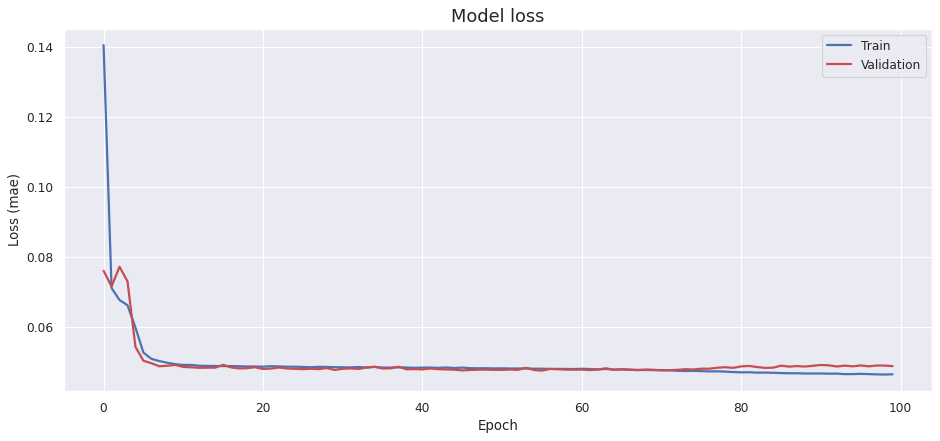

In [12]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.1)

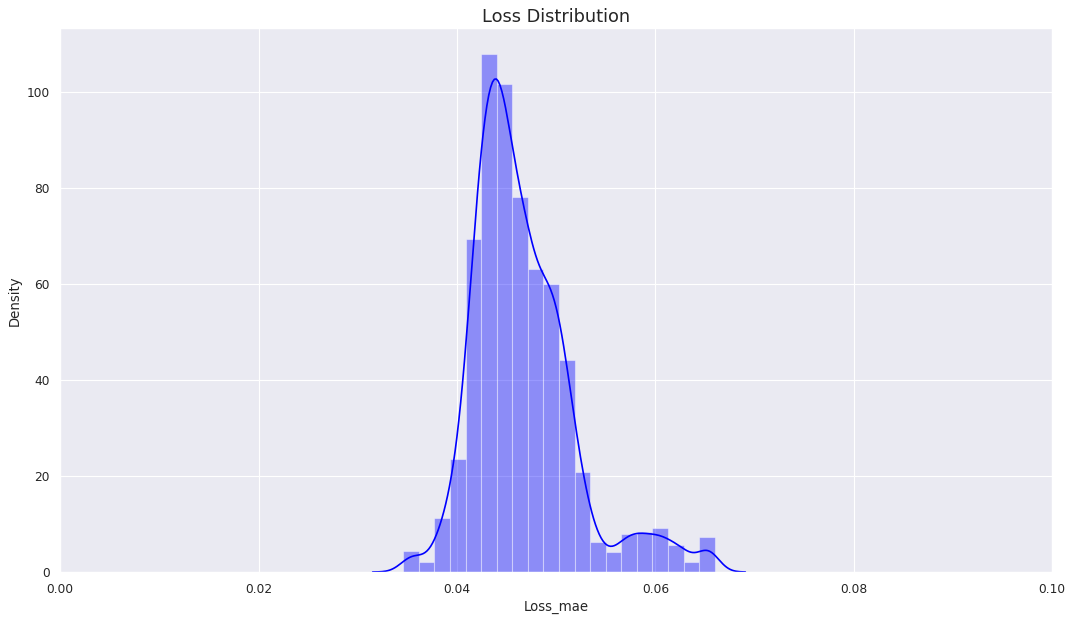

In [30]:
# plot the loss distribution of the training set
# reconstruct the training dataset (predicting)
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

# compute the loss (error between the predcted training and the original training)
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.1])

In [31]:
# compute a threshold -> four std from the mean of the loss
thre = np.mean(scored,axis=0)[0]+3*np.std(scored,axis=0)[0]
thre

0.06215663353193658

In [32]:
 scored["Loss_mae"].max()

0.06597190892016211

## the outliers are the points that have loss higher than the threshold
## 

In [33]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index =test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = thre# 0.175
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2010-05-04,0.051667,0.062157,False
2010-05-05,0.051951,0.062157,False
2010-05-06,0.051745,0.062157,False
2010-05-07,0.052233,0.062157,False
2010-05-08,0.051886,0.062157,False


In [34]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = thre
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [59]:
print(scored[scored["Anomaly"]==True].shape)
scored[scored["Anomaly"]==True][:10]

(82, 3)


,Loss_mae,Threshold,Anomaly
2001-07-03,0.062184,0.062157,True
2001-07-04,0.062366,0.062157,True
2001-07-05,0.062583,0.062157,True
2001-07-06,0.062314,0.062157,True
2001-07-07,0.062445,0.062157,True
2001-07-08,0.062396,0.062157,True
2002-04-01,0.062211,0.062157,True
2002-04-02,0.062586,0.062157,True
2002-04-03,0.062783,0.062157,True
2002-04-04,0.062469,0.062157,True


In [57]:
print(scored[scored["Anomaly"]==True].shape)
anomaly = scored[scored["Anomaly"]==True].index
anomaly

(82, 3)


Index([2001-07-03, 2001-07-04, 2001-07-05, 2001-07-06, 2001-07-07, 2001-07-08,
       2002-04-01, 2002-04-02, 2002-04-03, 2002-04-04, 2002-04-05, 2002-04-06,
       2002-04-07, 2002-04-08, 2002-04-09, 2002-04-10, 2002-04-11, 2002-04-12,
       2002-04-13, 2002-04-14, 2002-04-15, 2002-04-16, 2002-04-17, 2002-04-18,
       2002-04-19, 2002-04-20, 2002-04-21, 2002-04-22, 2002-04-23, 2002-04-24,
       2002-04-25, 2002-04-26, 2002-04-27, 2002-04-28, 2002-04-29, 2002-04-30,
       2002-05-01, 2002-05-02, 2002-05-03, 2002-05-04, 2002-05-05, 2002-05-06,
       2002-05-07, 2002-05-08, 2002-05-09, 2002-05-10, 2002-05-11, 2002-05-12,
       2002-05-13, 2002-05-14, 2002-05-15, 2002-05-16, 2002-05-17, 2002-05-18,
       2002-05-19, 2002-05-20, 2002-05-21, 2002-05-22, 2002-05-23, 2002-05-24,
       2002-05-25, 2002-05-26, 2002-05-27, 2002-05-28, 2002-05-29, 2002-05-30,
       2011-05-19, 2011-05-20, 2011-05-21, 2011-05-22, 2011-05-23, 2011-05-24,
       2011-05-31, 2011-06-01, 2011-06-02, 2011-06-0

<AxesSubplot:>

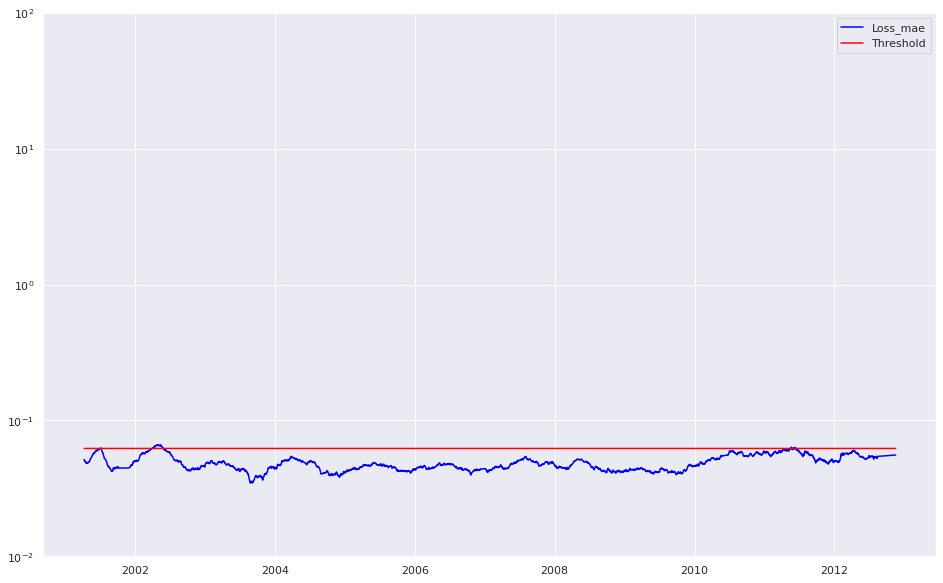

In [37]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,10), ylim=[1e-2,1e2], color=['blue','red'])


# with lag of 100 days, threshold 3 std of the mean of loss

Text(0.5, 1.0, 'prec')

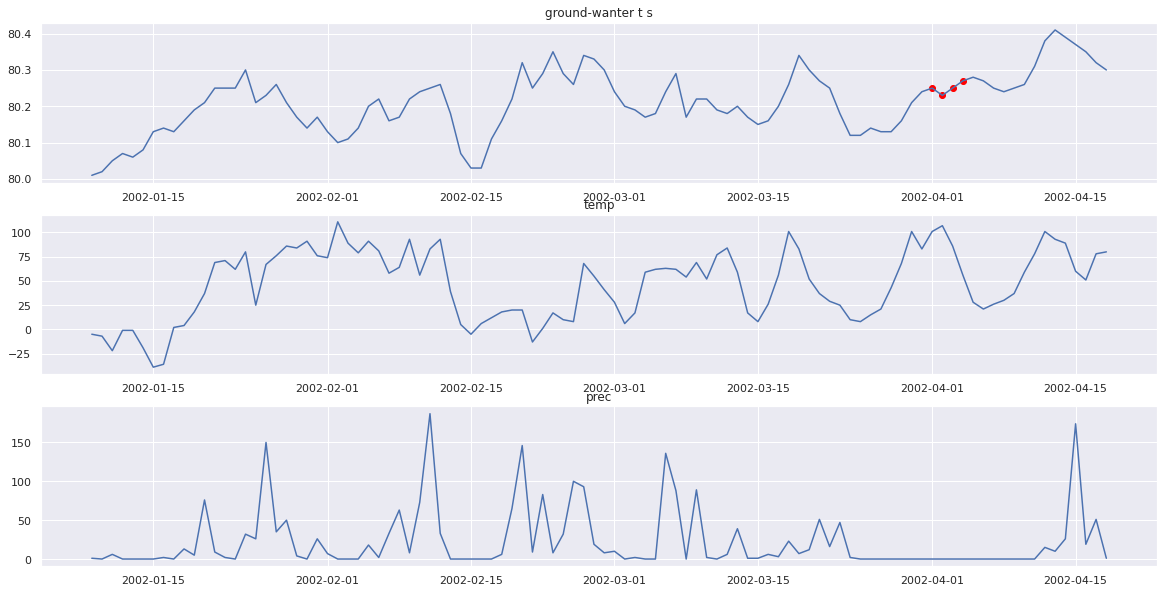

In [56]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 220,320
#a,b = 325,335
axs[0].plot(df["var1(t)"][a:b])
axs[0].scatter(anomaly[6:10], df["var1(t)"][anomaly][6:10], color="red") #df["var1(t)"]
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["var2(t)"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["var3(t)"][a:b])
axs[2].set_title('prec')